In [1]:
%load_ext autoreload
%autoreload 2

import jax
from jax import numpy as jnp
from jax import random
import flax
import optax
import distrax
import tensorflow as tf
import tensorflow_datasets as tfds
from clu import preprocess_spec
import matplotlib.pyplot as plt

from NeurReps import preprocess_utils

In [2]:
BATCH_SIZE = 256

In [3]:
rng = random.PRNGKey(42)

## Get Data

In [4]:
rng, shuffle_rng, pp_rng = random.split(rng, num=3)

In [5]:
pp_train = 'value_range(-1, 1)|random_rotate(-45, 45, fill_value=-1)|keep(["image"])'
preprocess_fn = preprocess_spec.parse(
          spec=pp_train, available_ops=preprocess_utils.all_ops())

def preprocess_with_rng(example_index, features):
    example_index = tf.cast(example_index, tf.int32)
    features["rng"] = tf.random.experimental.stateless_fold_in(
        tf.cast(pp_rng, tf.int64), example_index)
    processed = preprocess_fn(features)
    # del processed["rng"]
    return processed

In [6]:
ds = tfds.load('MNIST', split='train')
ds = ds.shuffle(10_000, seed=shuffle_rng[0])
# NOTE: ordering of PP and repeat is important! 
# PP first -> same seed each time we see same example.
# PP last -> diff seed each time we see same example. Effectively more data.
ds = ds.enumerate().map(preprocess_with_rng, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.repeat()
ds = ds.batch(batch_size=BATCH_SIZE)
ds = ds.prefetch(tf.data.AUTOTUNE)
ds = ds.as_numpy_iterator()

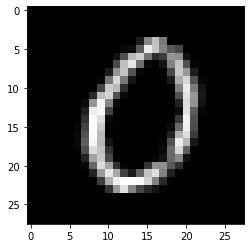

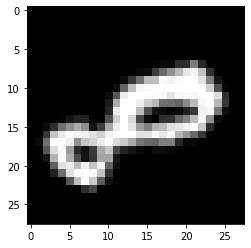

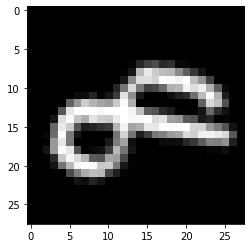

In [7]:
for _ in range(3):
    batch = next(ds)
    plt.imshow(batch['image'][0], cmap='gray')
    plt.show()

## Build Model